# Physique des Marchés, TP1 : Faits Stylisés
**Martin Pasche -- Hugo Yeremian**

### Libraries

In [15]:
import sys
import os
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
import scipy.stats as stats
import seaborn as sns
import powerlaw
    
from itertools import groupby
from operator import itemgetter
from scipy.signal import find_peaks
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.stats import norm, gaussian_kde, expon, mstats, laplace
from statsmodels.graphics.gofplots import qqplot
from statsmodels.distributions.empirical_distribution import ECDF

#### Helper function

In [16]:
files = sorted(glob.glob("data/2017-*-AAPL.OQ-bbo.csv.gz"))

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

# function not directly in my folder
from loadbbo import load_TRTH_bbo

# 2. Obtenir des données

## 2.1. Données Journalières

In [17]:
aapl = yf.Ticker('AAPL')
data_daily = aapl.history(interval='1d', start='2002-01-02')
data_daily.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2002-01-02 00:00:00-05:00,0.331782,0.350590,0.330428,0.350590,529496800,0.0,0.0
2002-01-03 00:00:00-05:00,0.346076,0.357361,0.342615,0.354803,612007200,0.0,0.0
2002-01-04 00:00:00-05:00,0.351192,0.360371,0.345926,0.356459,409976000,0.0,0.0
2002-01-07 00:00:00-05:00,0.356910,0.361123,0.342315,0.344572,444584000,0.0,0.0
2002-01-08 00:00:00-05:00,0.342315,0.346829,0.337951,0.340208,450038400,0.0,0.0


## 2.2. Données Intraday

In [18]:
data_list = [load_TRTH_bbo(file) for file in files]
data_intraday = pd.concat(data_list)

# 3. Calcul des rendements

## 3.1 Données Journalières

In [19]:
data_daily["Returns"] = np.log(data_daily["Close"]).diff()
returns_daily = data_daily["Returns"].dropna()

Text(0.5, 1.0, 'Daily log returns of AAPL Stock')

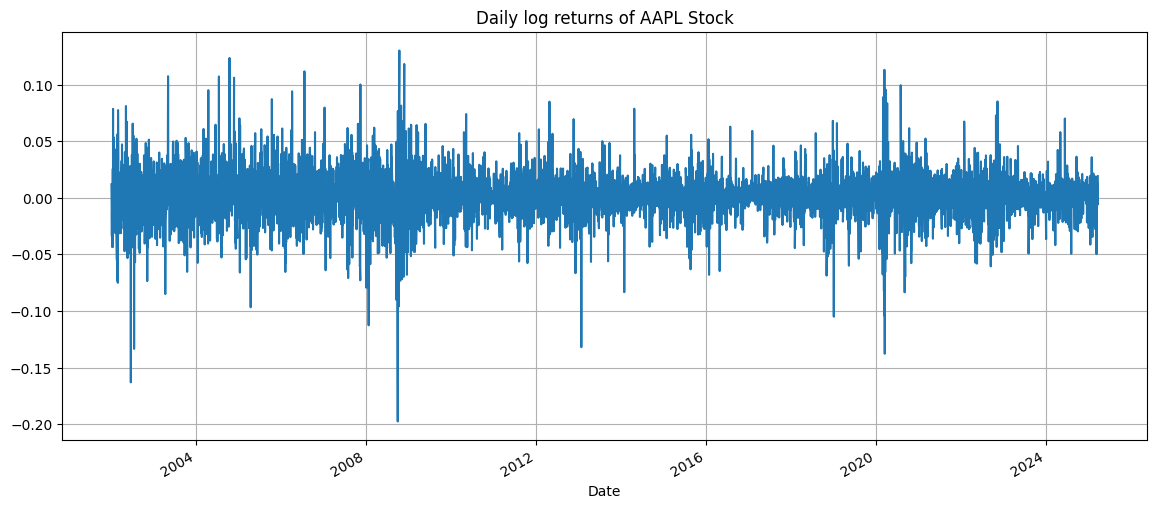

In [20]:
plt.figure(figsize=(14, 6))
returns_daily.plot()
plt.grid()
plt.title('Daily log returns of AAPL Stock')

Text(0.5, 1.0, 'Cumulative Return (from Log-Returns) of AAPL')

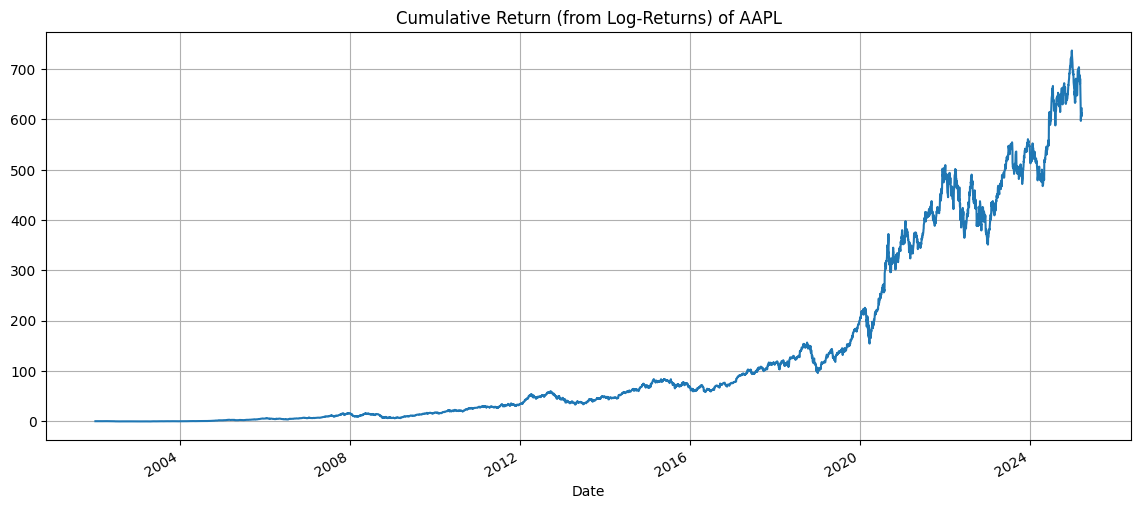

In [21]:
plt.figure(figsize=(14, 6))
# total percentage of cumulative return
(np.exp(returns_daily.cumsum()) - 1).plot()
plt.grid()
plt.title("Cumulative Return (from Log-Returns) of AAPL")

## 3.2 Données Intraday

### 3.2.1. Sanity Checks

In [22]:
# be sure that the markets are open ub the US (AAPL Stock)
data_intraday = data_intraday.between_time('09:30:00','16:00:00')

# exact same lines are avoided with same timestamps
data_intraday = data_intraday.reset_index().drop_duplicates().set_index("xltime")

# be sure of the timeline
data_intraday = data_intraday.sort_index()

# sanity checks of quantities
data_intraday = data_intraday[
    (data_intraday["bid-price"] > 0) &
    (data_intraday["ask-price"] > 0) &
    (data_intraday["bid-volume"] > 0) &
    (data_intraday["ask-volume"] > 0)
]

### 3.2.2 Transformations et Ajout d'informations



In [23]:
data_intraday['Mid-Price'] = (data_intraday['bid-price'] + data_intraday['ask-price']) / 2
log_mid_returns = np.log(data_intraday['Mid-Price']).diff()

# you sum to resample ln(P_30secs / P_0)
returns_30s = log_mid_returns.resample('30s').sum()
returns_5s = log_mid_returns.resample('5s').sum()
returns_1m = log_mid_returns.resample('1min').sum()
returns_5m = log_mid_returns.resample('5min').sum()

returns_30s = returns_30s.dropna()
returns_5s = returns_5s.dropna()
returns_1m = returns_1m.dropna()
returns_5m = returns_5m.dropna()

# cumulative log returns
cumulative_returns_30s = returns_30s.cumsum()
cumulative_returns_5s = returns_5s.cumsum()
cumulative_returns_1m = returns_1m.cumsum()
cumulative_returns_5m = returns_5m.cumsum()

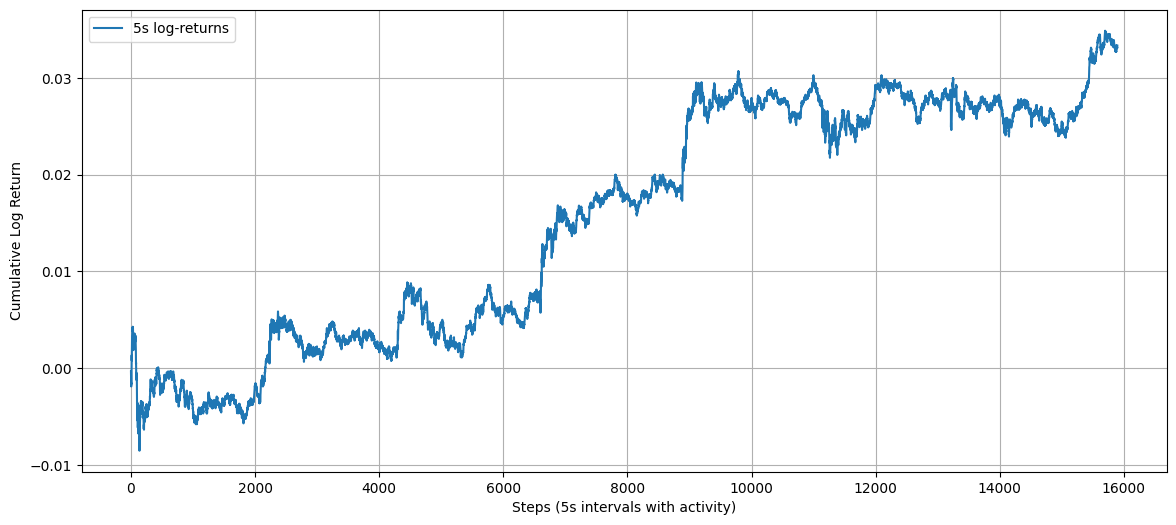

In [24]:
# to visualy not see gaps
returns_5s_plot = returns_5s[returns_5s != 0]
# with filter of 0 values
cum_returns_5s = returns_5s_plot.cumsum()

plt.figure(figsize=(14, 6))
plt.plot(cum_returns_5s.values, label='5s log-returns')
plt.xlabel('Steps (5s intervals with activity)')
plt.ylabel('Cumulative Log Return')
plt.grid()
plt.legend()
plt.show()


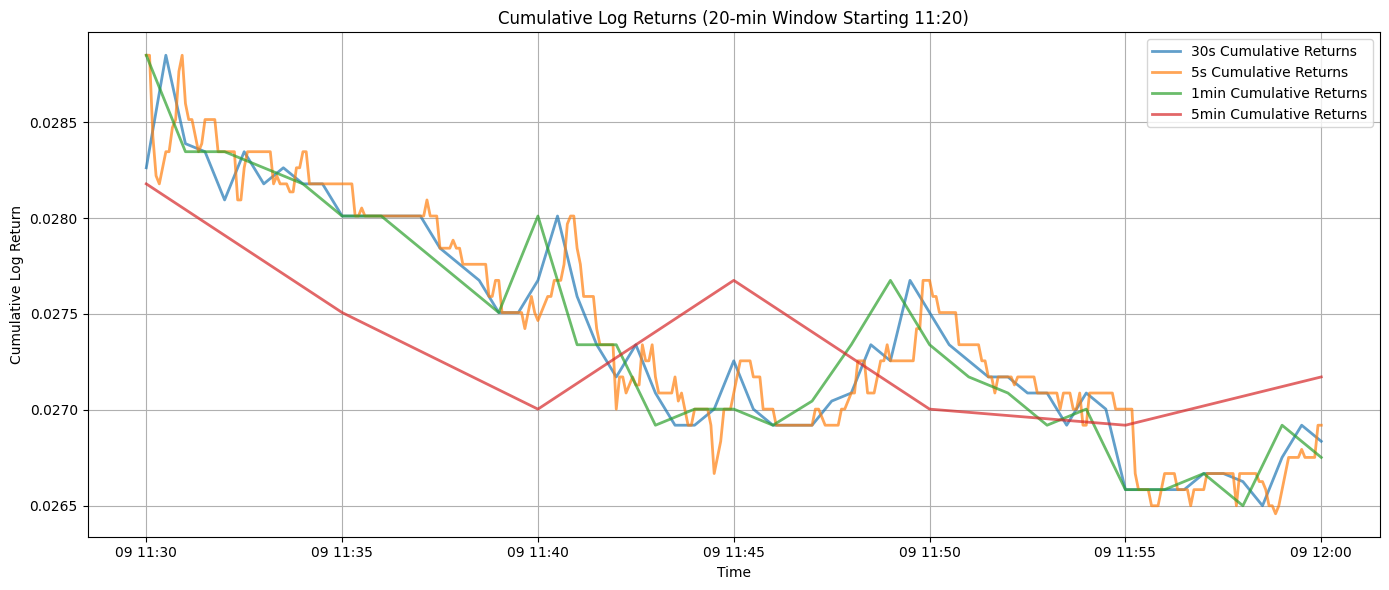

In [25]:
start_time = '2017-01-09 11:30:00'
end_time = '2017-01-09 12:00:00'

# Slicing window
window_30s = cumulative_returns_30s.loc[start_time:end_time]
window_5s = cumulative_returns_5s.loc[start_time:end_time]
window_1m = cumulative_returns_1m.loc[start_time:end_time]
window_5m = cumulative_returns_5m.loc[start_time:end_time]

plt.figure(figsize=(14, 6))
plt.plot(window_30s, label='30s Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_5s, label='5s Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_1m, label='1min Cumulative Returns', linewidth=2, alpha=0.7)
plt.plot(window_5m, label='5min Cumulative Returns', linewidth=2, alpha=0.7)
plt.title('Cumulative Log Returns (20-min Window Starting 11:20)')
plt.xlabel('Time')
plt.ylabel('Cumulative Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 4. Analyse Empirique
## 4.1 Rendements : types de distribution
### 4.1.1. Gaussianité : Données Journalières

In [26]:
returns_daily = returns_daily[returns_daily != 0]

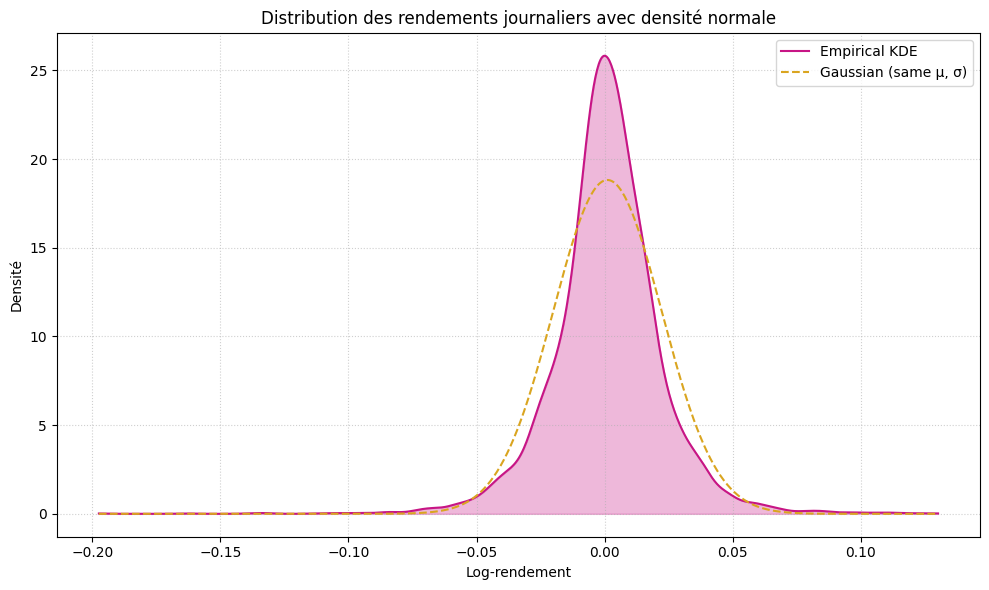

In [27]:
x = np.linspace(returns_daily.min(), returns_daily.max(), 1000)

kde = gaussian_kde(returns_daily)
kde_values = kde(x)
gaussian_pdf = norm.pdf(x, loc=returns_daily.mean(), scale=returns_daily.std())

plt.figure(figsize=(10, 6))
plt.plot(x, kde_values, label='Empirical KDE', color='mediumvioletred')
plt.fill_between(x, kde_values, alpha=0.3, color='mediumvioletred')
plt.plot(x, gaussian_pdf, label='Gaussian (same μ, σ)', linestyle='--', color='goldenrod')
plt.title("Distribution des rendements journaliers avec densité normale")
plt.xlabel("Log-rendement")
plt.ylabel("Densité")
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()

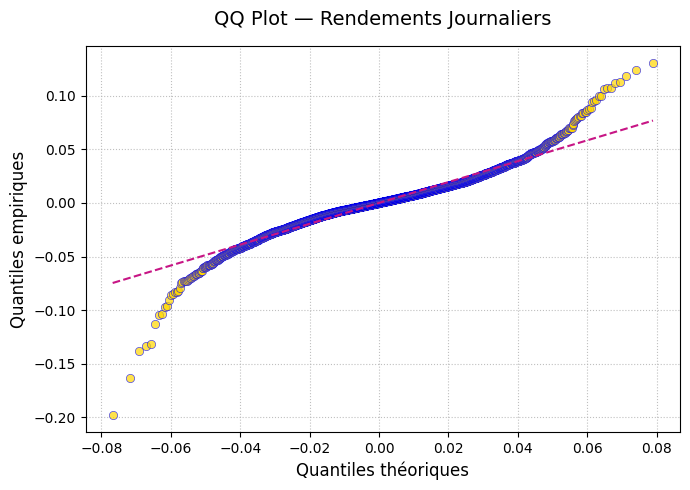

In [28]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

stats.probplot(returns_daily, dist="norm", 
               sparams=(np.mean(returns_daily), np.std(returns_daily)), 
               plot=ax)

ax.get_lines()[1].set_color("mediumvioletred")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[0].set_markerfacecolor("gold")
ax.get_lines()[0].set_markeredgewidth(0.5)
ax.get_lines()[0].set_alpha(0.7)
ax.set_title("QQ Plot — Rendements Journaliers", fontsize=14, pad=15)
ax.set_xlabel("Quantiles théoriques", fontsize=12)
ax.set_ylabel("Quantiles empiriques", fontsize=12)
ax.grid(True, linestyle=":", alpha=0.8)

plt.tight_layout()
plt.show()


### 4.1.1. Gaussianité : Données Intraday

In [29]:
returns_1m = returns_1m[returns_1m != 0]

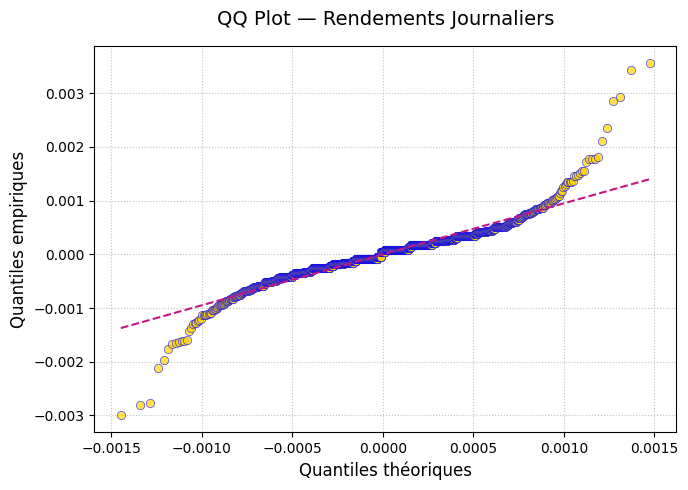

In [30]:
fig = plt.figure(figsize=(7, 5))
ax = fig.add_subplot(111)

stats.probplot(returns_1m, dist="norm", 
               sparams=(np.mean(returns_1m), np.std(returns_1m)), 
               plot=ax)

ax.get_lines()[1].set_color("mediumvioletred")
ax.get_lines()[1].set_linestyle("--")
ax.get_lines()[0].set_markerfacecolor("gold")
ax.get_lines()[0].set_markeredgewidth(0.5)
ax.get_lines()[0].set_alpha(0.7)
ax.set_title("QQ Plot — Rendements Journaliers", fontsize=14, pad=15)
ax.set_xlabel("Quantiles théoriques", fontsize=12)
ax.set_ylabel("Quantiles empiriques", fontsize=12)
ax.grid(True, linestyle=":", alpha=0.8)

plt.tight_layout()
plt.show()

#### Interprétation :

Dans les deux cas, la distribution observée s’écarte nettement de la loi normale. Toutefois, on remarque qu’en diminuant la fréquence d’échantillonnage des rendements, la distribution tend à avoir des queues moins épaisses.

### 4.1.2. Comparaison des rendements intraday :

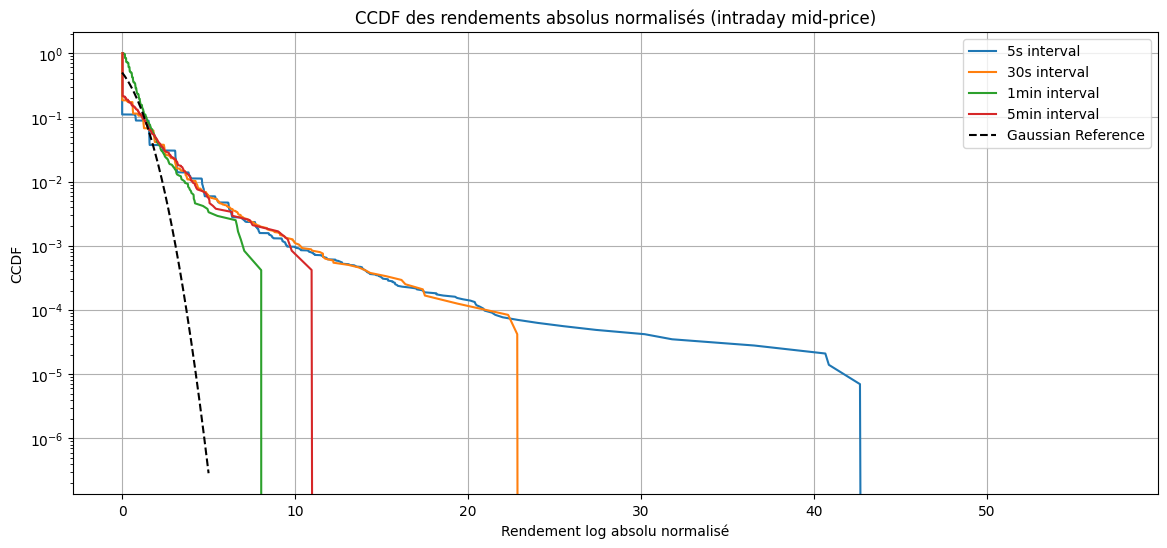

In [31]:
plt.figure(figsize=(14, 6))

returns_dict = {
    '5s': returns_5s,
    '30s': returns_30s,
    '1min': returns_1m,
    '5min': returns_5m
}

for label, returns in returns_dict.items():
    # Normalisation des rendements (z-score)
    normalized_abs_returns = np.abs((returns - returns.mean()) / returns.std())

    # CCDF
    sorted_data = np.sort(normalized_abs_returns)
    ccdf = 1. - np.arange(1, len(sorted_data)+1) / len(sorted_data)

    plt.semilogy(sorted_data, ccdf, label=f'{label} interval')

# Courbe de référence gaussienne
gaussian_x = np.linspace(0, 5, 1000)
gaussian_ccdf = 1. - stats.norm.cdf(gaussian_x)
plt.semilogy(gaussian_x, gaussian_ccdf, 'k--', label='Gaussian Reference')

plt.title('CCDF des rendements absolus normalisés (intraday mid-price)')
plt.xlabel('Rendement log absolu normalisé')
plt.ylabel('CCDF')
plt.legend()
plt.grid(True)
plt.show()


### 4.2.1 Queues Lourdes : Données Journalières

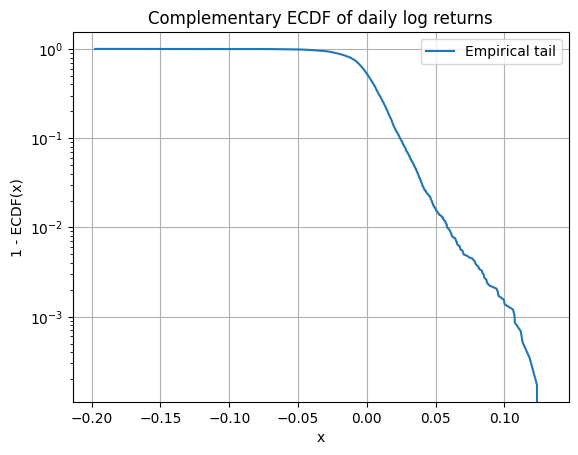

In [32]:
cdflr = ECDF(returns_daily.to_numpy())

# Loi du survivant
plt.plot(cdflr.x, 1 - cdflr.y, label='Empirical tail')

plt.yscale('log')
plt.title('Complementary ECDF of daily log returns')
plt.xlabel('x')
plt.ylabel('1 - ECDF(x)')
plt.legend()
plt.grid(True)


#### Interprétation: (pour le premier graphe vu en cours)

Queue plus lourde que l’exponentielle par la concavité du profil de la fonction du survivant.

$$\mathbb{P}(X > x) = \exp(-x) \Rightarrow \log \mathbb{P}(X > x) = -x$$

Donc en échelle semi-log, on aurait une ligne droite de pente -1.

Il y a plus de valeurs extrêmes que prévu par une loi exponentielle -> queue lourde.

### 4.2.2 Queues Lourdes : Données Intraday

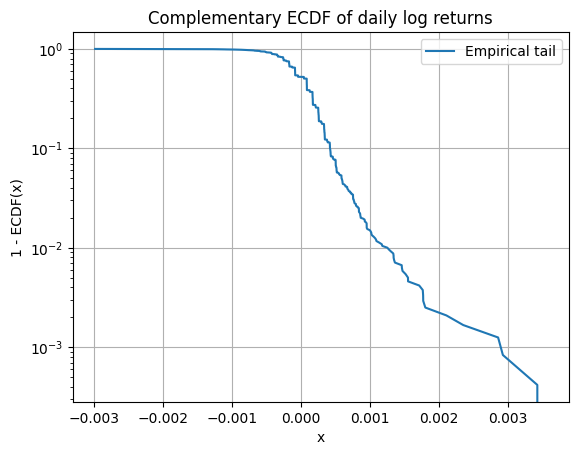

In [33]:
cdflr = ECDF(returns_1m.to_numpy())

# Loi du survivant
plt.plot(cdflr.x, 1 - cdflr.y, label='Empirical tail')

plt.yscale('log')
plt.title('Complementary ECDF of daily log returns')
plt.xlabel('x')
plt.ylabel('1 - ECDF(x)')
plt.legend()
plt.grid(True)

### Interprétation: (supplémentaire par deuxième graphe)
On remarque qu'encore plus d'évènements viennent conclure à une densité non exponentielle, au-delà même de l'hypothèse que les rendements à valeur absolue proche de 0, on remarque qu'ici c'est toutes les valeurs de rendements possibles qui ne suivent pas de loi exponentielle.

### 4.3.1. QQ-Plot de distribution exponentielle : Données Journalières

On considère une variable aléatoire réelle $r$, typiquement un **rendement logarithmique**.

On définit une version **normalisée** :

$$
x = \frac{|r|}{\mathbb{E}(|r|)}
$$

Cela permet de supprimer l'effet d'échelle et de comparer la forme de la distribution (notamment dans la queue) à celle d'une loi exponentielle de moyenne 1.

In [34]:
r = returns_daily.to_numpy()
r_normalized = np.abs(r) / np.mean(np.abs(r))

# calcul des quantiles empiriques sur une grille de probas phi
r_sorted = np.sort(r_normalized)
n = len(r_sorted)

# générer une grille de probabilités entre 0 et 1
phi = np.linspace(1 / (n + 1), n / (n + 1), n)

# quantiles d'une loi exp(1) --> formule fermée
q_exp = -np.log(1 - phi)

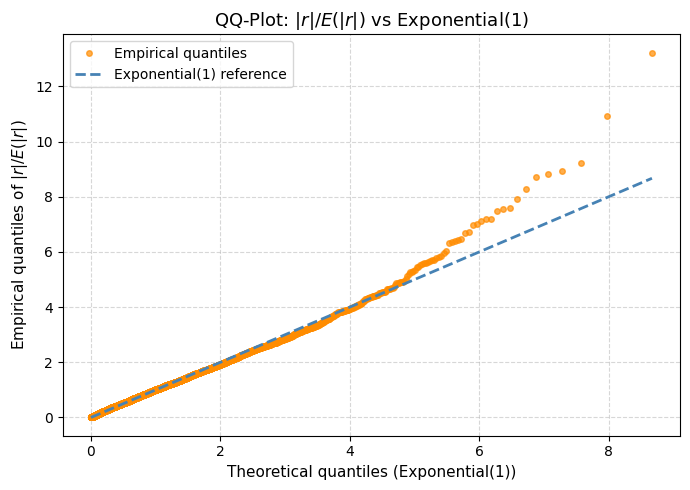

In [35]:
plt.figure(figsize=(7, 5))

plt.plot(q_exp, r_sorted, 'o', markersize=4, alpha=0.7, color='darkorange', label='Empirical quantiles')
plt.plot(q_exp, q_exp, '--', color='steelblue', linewidth=2, label='Exponential(1) reference')

plt.xlabel('Theoretical quantiles (Exponential(1))', fontsize=11)
plt.ylabel('Empirical quantiles of $|r|/E(|r|)$', fontsize=11)
plt.title('QQ-Plot: $|r|/E(|r|)$ vs Exponential(1)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### Interprétation :

La queue de la distribution est plus lourde que celle de l'exponentielle — ce qui est un signal fort de heavy tails comme précédemment testé. Fait stylisé vérifé !

### 4.3.2. QQ-Plot de distribution exponentielle : Données Intraday

In [36]:
r_1m = returns_1m.to_numpy()
r_1m_normalized = np.abs(r_1m) / np.mean(np.abs(r_1m))

# calcul des quantiles empiriques sur une grille de probas phi
r_1m_sorted = np.sort(r_1m_normalized)
n_1m = len(r_1m_sorted)

# générer une grille de probabilités entre 0 et 1
phi_1m = np.linspace(1 / (n_1m + 1), n_1m / (n_1m + 1), n_1m)

# quantiles d'une loi exp(1) --> formule fermée
q_exp_1m = -np.log(1 - phi_1m)

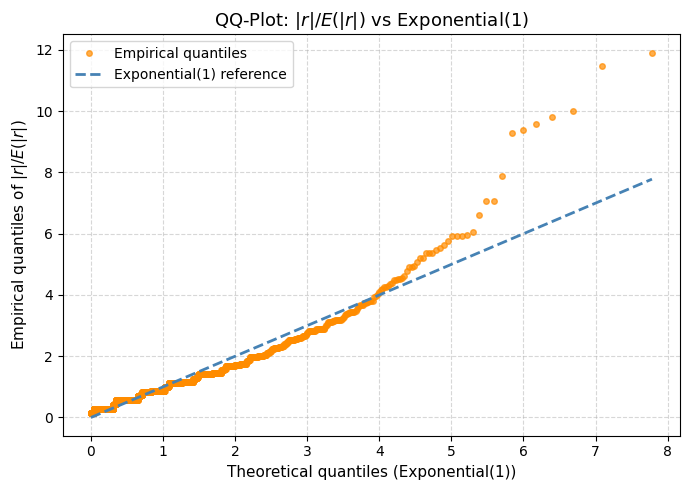

In [37]:
plt.figure(figsize=(7, 5))

plt.plot(q_exp_1m, r_1m_sorted, 'o', markersize=4, alpha=0.7, color='darkorange', label='Empirical quantiles')
plt.plot(q_exp_1m, q_exp_1m, '--', color='steelblue', linewidth=2, label='Exponential(1) reference')

plt.xlabel('Theoretical quantiles (Exponential(1))', fontsize=11)
plt.ylabel('Empirical quantiles of $|r|/E(|r|)$', fontsize=11)
plt.title('QQ-Plot: $|r|/E(|r|)$ vs Exponential(1)', fontsize=13)

plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

### 4.4.1. Calcul de la distance maximale entre les quantiles empiriques de |r|/E(|r|) et les quantiles d’une distribution exponentielle de moyenne 1 : Données Journalières

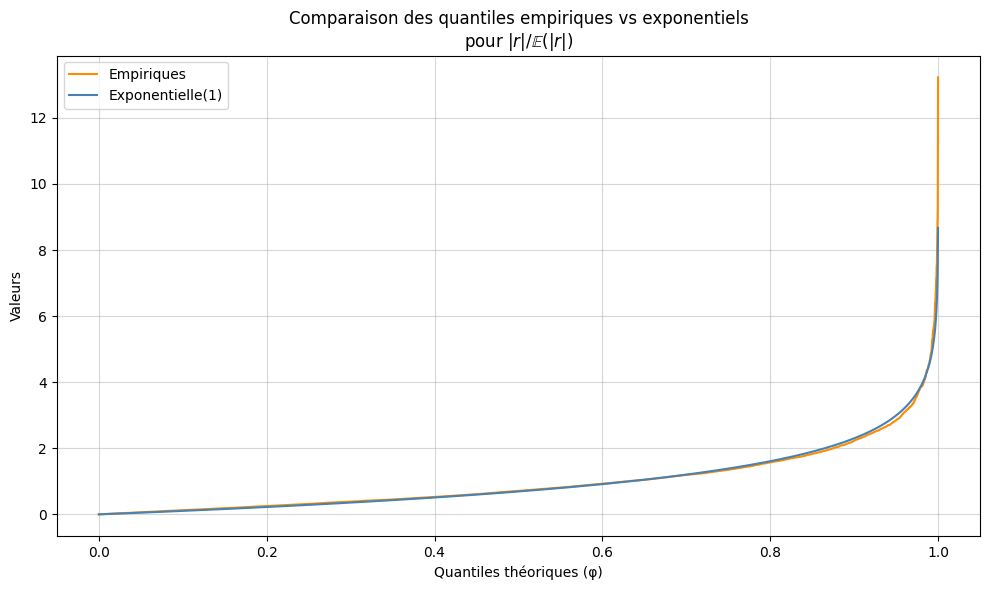

In [38]:
#q_emp = mstats.mquantiles(r_normalized, prob=phi)
q_emp = r_sorted

plt.figure(figsize=(10, 6))
plt.plot(phi, q_emp, label="Empiriques", color='darkorange')
plt.plot(phi, q_exp, '-', label="Exponentielle(1)", color='steelblue')

plt.xlabel("Quantiles théoriques (φ)")
plt.ylabel("Valeurs")
plt.title("Comparaison des quantiles empiriques vs exponentiels\npour $|r|/\mathbb{E}(|r|)$")
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distance maximale quantiles empiriques et exponentiels')

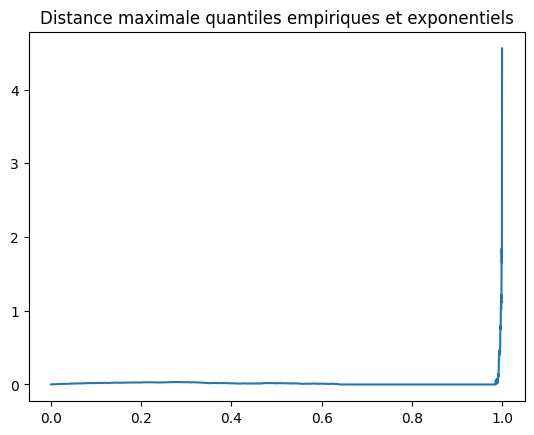

In [39]:
plt.plot(phi,np.maximum(q_emp - q_exp, 0))
plt.title("Distance maximale quantiles empiriques et exponentiels")

In [40]:
distance_maximale = np.max(np.maximum(q_emp - q_exp, 0))
print("Distance maximale entre les quantiles exp et empirique: ", distance_maximale)

Distance maximale entre les quantiles exp et empirique:  4.556684383885003


### 4.4.2. Calcul de la distance maximale entre les quantiles empiriques de |r|/E(|r|) et les quantiles d’une distribution exponentielle de moyenne 1 : Données Intraday

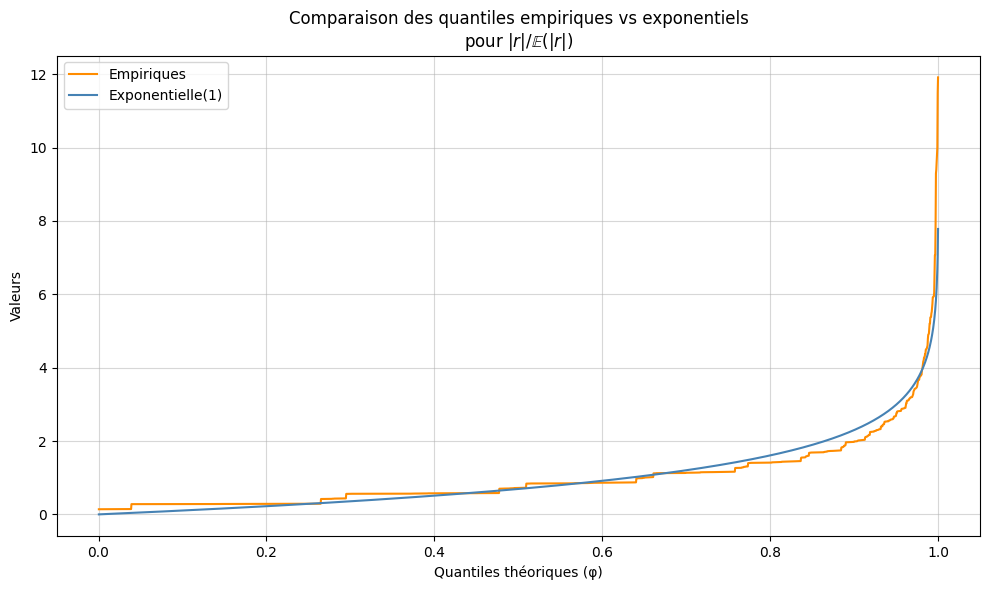

In [41]:
#q_emp = mstats.mquantiles(r_normalized, prob=phi)
q_emp_1m = r_1m_sorted

plt.figure(figsize=(10, 6))
plt.plot(phi_1m, q_emp_1m, label="Empiriques", color='darkorange')
plt.plot(phi_1m, q_exp_1m, '-', label="Exponentielle(1)", color='steelblue')

plt.xlabel("Quantiles théoriques (φ)")
plt.ylabel("Valeurs")
plt.title("Comparaison des quantiles empiriques vs exponentiels\npour $|r|/\mathbb{E}(|r|)$")
plt.grid(True, linestyle='-', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distance maximale quantiles empiriques et exponentiels')

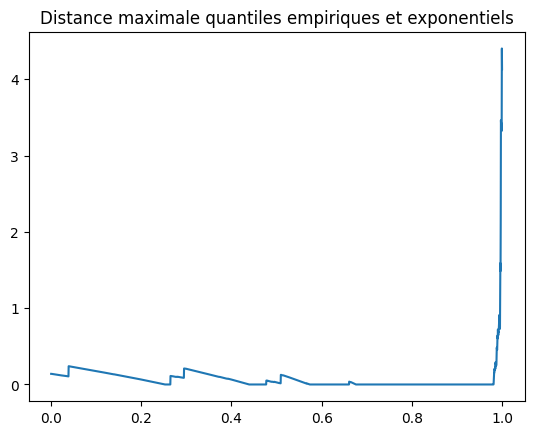

In [42]:
plt.plot(phi_1m, np.maximum(q_emp_1m - q_exp_1m, 0))
plt.title("Distance maximale quantiles empiriques et exponentiels")

In [43]:
distance_maximale_1m = np.max(np.maximum(q_emp_1m - q_exp_1m, 0))
print("Distance maximale entre les quantiles exp et empirique: ", distance_maximale_1m)

Distance maximale entre les quantiles exp et empirique:  4.40271607145184


### 4.5.1. Génération de rendements iid par Laplace : Data Journalières

On considère une variable aléatoire $ \xi $ suivant une **loi de Laplace centrée** :

$$
\xi \sim \text{Laplace}(0, b)
$$
La densité de probabilité de $ \xi $ est donnée par :

$$
f_\xi(x) = \frac{1}{2b} e^{-\frac{|x|}{b}}, \quad x \in \mathbb{R}
$$
Cette loi est symétrique et à "queues épaisses", souvent utilisée pour modéliser des rendements financiers avec des chocs important et en normalisant cette variable par son espérance :

$$
Y = \frac{|\xi|}{\mathbb{E}[|\xi|]}
$$

In [44]:
laplace_r = laplace.rvs(size=1_000_000)
laplace_normalized = np.abs(laplace_r) / np.mean(np.abs(laplace_r))

# Quantiles empiriques de la variable normalisée Laplace
q_emp_laplace = mstats.mquantiles(laplace_normalized, prob=phi)

excess_laplace = np.maximum(q_emp - q_emp_laplace,0)
distance_max_laplace = np.max(excess_laplace)

print("Distance max (Laplace vs Exponentielle) :", distance_max_laplace)

Distance max (Laplace vs Exponentielle) : 4.590789069703673


/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_14124/2934549935.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


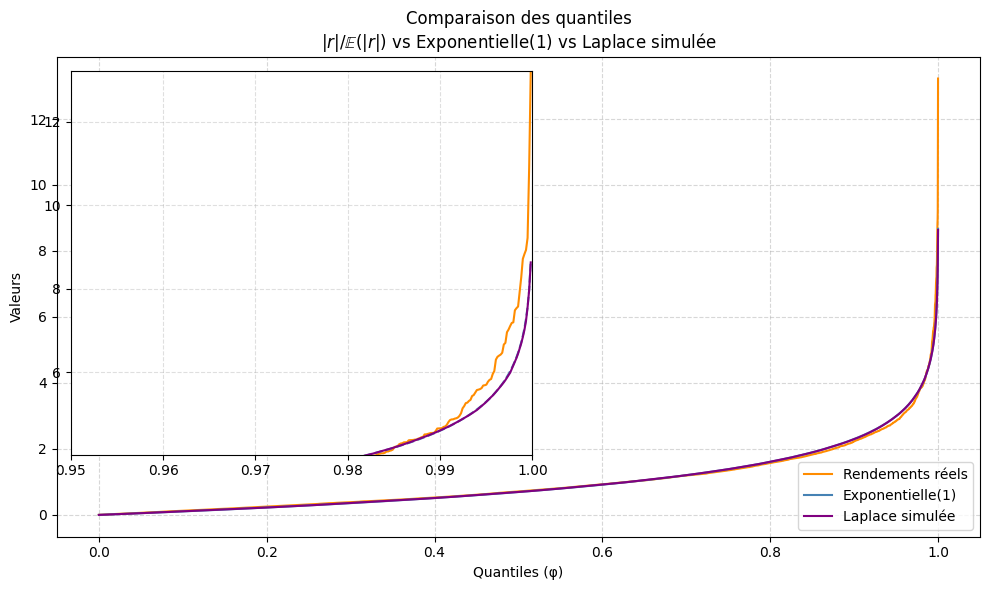

In [45]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(phi, q_emp, label="Rendements réels", color='darkorange')
ax.plot(phi, q_exp, label="Exponentielle(1)", color='steelblue')
ax.plot(phi, q_emp_laplace, label="Laplace simulée", color='purple')

ax.set_xlabel("Quantiles (φ)")
ax.set_ylabel("Valeurs")
ax.set_title("Comparaison des quantiles\n$|r|/\mathbb{E}(|r|)$ vs Exponentielle(1) vs Laplace simulée")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right')

axins = inset_axes(ax, width="50%", height="80%", loc='upper left', borderpad=1)
axins.plot(phi, q_emp, color='darkorange')
axins.plot(phi, q_exp, '--', color='steelblue')
axins.plot(phi, q_emp_laplace, color='purple')
axins.set_xlim(0.95, 1.0)  # Zoom in on the tail 
axins.set_ylim(min(q_emp[-98:]), max(q_emp[-15:]))  # Adjust y-limits for tail
axins.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

### Interprétation à vérifier : (j'avais mal fait les distances dans le phi)La distance maximale entre les quantiles empiriques et ceux de l’exponentielle est plus grande pour les rendements réels que pour des données iid simulées selon une loi de Laplace.
Cela signifie que les rendements réels présentent des queues encore plus lourdes que celles prévues par une double exponentielle.

### Interprétation :

La queue de la distribution est plus lourde que celle de l'exponentielle — ce qui est un signal fort de heavy tails comme précédemment testé. Fait stylisé vérifé ! (et parfois même plus faible)

### 4.5.2. Génération de rendements iid par Laplace : Data Intraday

In [46]:
laplace_r_1m = laplace.rvs(size=1_000_000)
laplace_normalized_1m = np.abs(laplace_r_1m) / np.mean(np.abs(laplace_r_1m))

# Quantiles empiriques de la variable normalisée Laplace
q_emp_laplace_1m = mstats.mquantiles(laplace_normalized_1m, prob=phi_1m)

excess_laplace_1m = np.maximum(q_emp_1m - q_emp_laplace_1m,0)
distance_max_laplace_1m = np.max(excess_laplace_1m)

print("Distance max (Laplace vs Exponentielle) :", distance_max_laplace_1m)

Distance max (Laplace vs Exponentielle) : 4.384337207834193


/var/folders/nd/lbp9nypd0l328jm0b27jr8c00000gn/T/ipykernel_14124/3720845888.py:21: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


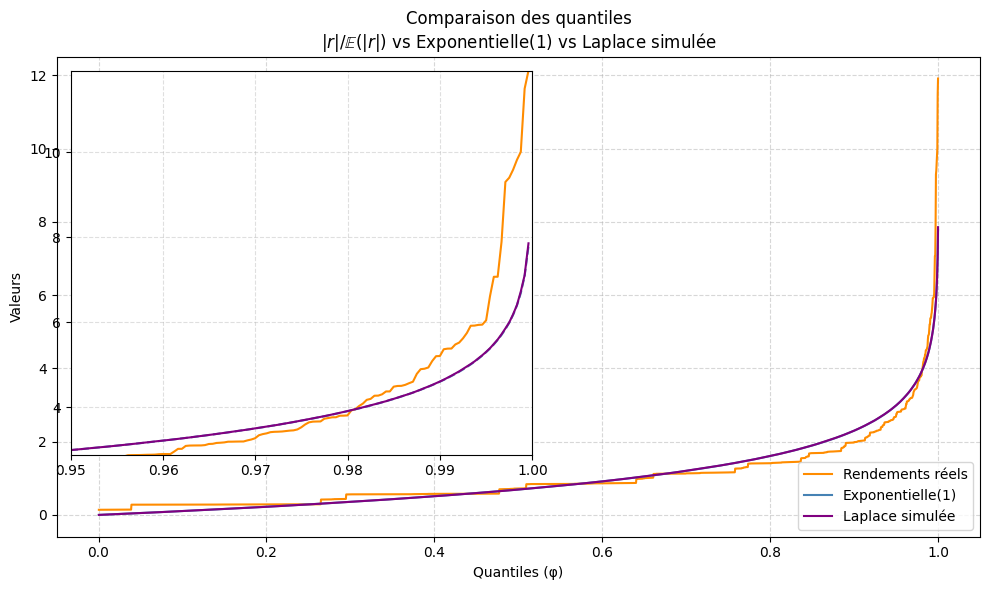

In [47]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(phi_1m, q_emp_1m, label="Rendements réels", color='darkorange')
ax.plot(phi_1m, q_exp_1m, label="Exponentielle(1)", color='steelblue')
ax.plot(phi_1m, q_emp_laplace_1m, label="Laplace simulée", color='purple')

ax.set_xlabel("Quantiles (φ)")
ax.set_ylabel("Valeurs")
ax.set_title("Comparaison des quantiles\n$|r|/\mathbb{E}(|r|)$ vs Exponentielle(1) vs Laplace simulée")
ax.grid(True, linestyle='--', alpha=0.5)
ax.legend(loc='lower right')

axins = inset_axes(ax, width="50%", height="80%", loc='upper left', borderpad=1)
axins.plot(phi_1m, q_emp_1m, color='darkorange')
axins.plot(phi_1m, q_exp_1m, '--', color='steelblue')
axins.plot(phi_1m, q_emp_laplace_1m, color='purple')
axins.set_xlim(0.95, 1.0)  # Zoom in on the tail 
axins.set_ylim(min(q_emp_1m[-98:]), max(q_emp_1m[-15:]))  # Adjust y-limits for tail
axins.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

#### Interprétation :

Cela ne reste pas évident que la double exponentielle simulée par une loi de Laplace puisse convenir pour simuler des rendements à évènements plus rares. Il semblerait que les rendements intraday sont bien plus erratiques à première vue que la distribution brute des rendements simulés par la loi exponentielle ou Laplace.

## 5.1.1 Exposant de la queue des log-returns : Data Journalières

L’objectif est de vérifier si la queue de la distribution des rendements absolus suit une **loi de puissance**, et si oui, d’en **estimer l’exposant**.

Une loi de puissance a la forme :

$$
P(x) \sim x^{-\alpha}
$$

où $ \alpha $ est l’exposant de la loi de puissance (power-law exponent). Cet exposant contrôle l'épaisseur de la queue : plus $ \alpha $ est petit, plus la queue est lourde.

Nous utilisons le paquet `powerlaw` qui permet :
- d’ajuster une loi de puissance aux données continues,
- d’estimer $ \alpha $ (appelé aussi `power_law.alpha`),
- de déterminer le point $ x_{\min} $ à partir duquel la loi de puissance s’applique,
- de produire une visualisation en échelle log-log de l’ajustement.

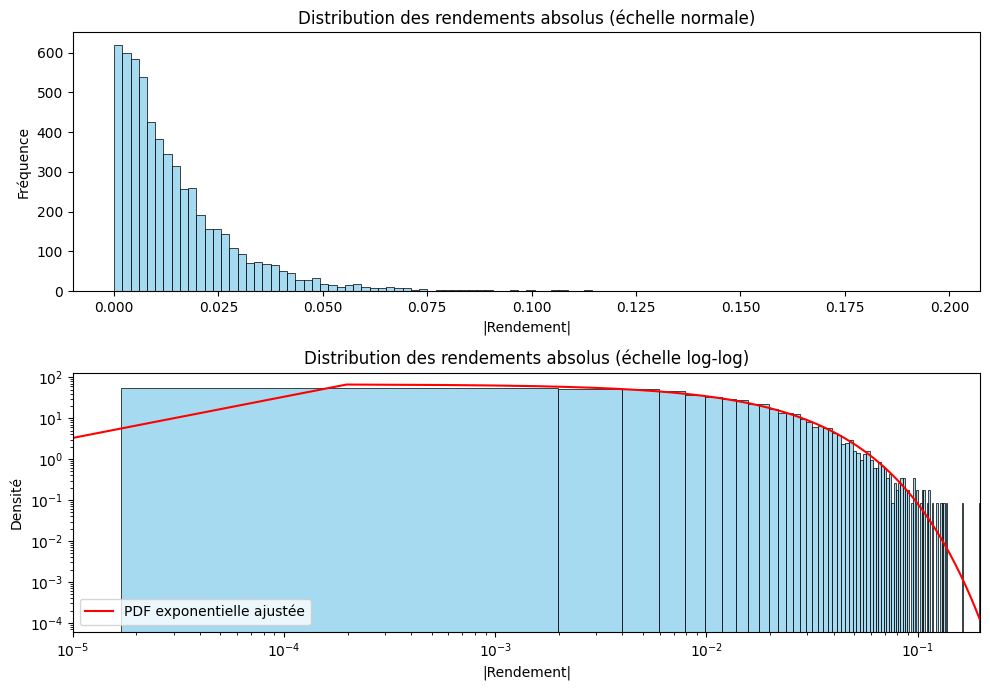

In [48]:
abs_returns = np.abs(returns_daily)
loc, scale = stats.expon.fit(abs_returns)   

x_fit = np.linspace(0, np.max(abs_returns), 1000)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

sns.histplot(abs_returns, kde=False, ax=axes[0], bins=100, color='skyblue')
axes[0].set_title('Distribution des rendements absolus (échelle normale)')
axes[0].set_xlabel('|Rendement|')
axes[0].set_ylabel('Fréquence')

sns.histplot(abs_returns, kde=False, stat='density', bins=100, ax=axes[1], color='skyblue')
sns.lineplot(x=x_fit, y=y_fit, color='red', ax=axes[1], label='PDF exponentielle ajustée')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e-5, np.max(abs_returns))
axes[1].set_xlabel('|Rendement|')
axes[1].set_ylabel('Densité')   
axes[1].set_title('Distribution des rendements absolus (échelle log-log)')
axes[1].legend()

plt.tight_layout()
plt.show()


#### with `Powerlaw` module :

Calculating best minimal value for power law fit


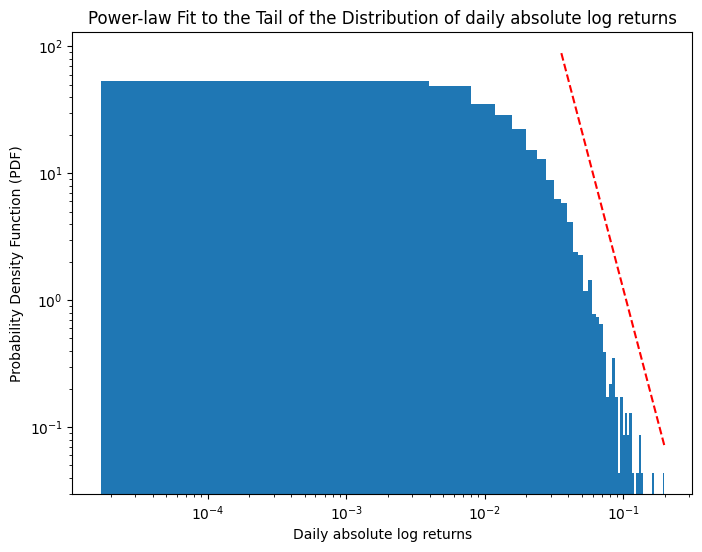

Power-law alpha: 4.158273673154614
Power-law xmin: 0.03569097390779363


In [49]:
fit = powerlaw.Fit(np.abs(returns_daily))

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(np.abs(returns_daily), bins=50, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Daily absolute log returns')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution of daily absolute log returns')
plt.show()

print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

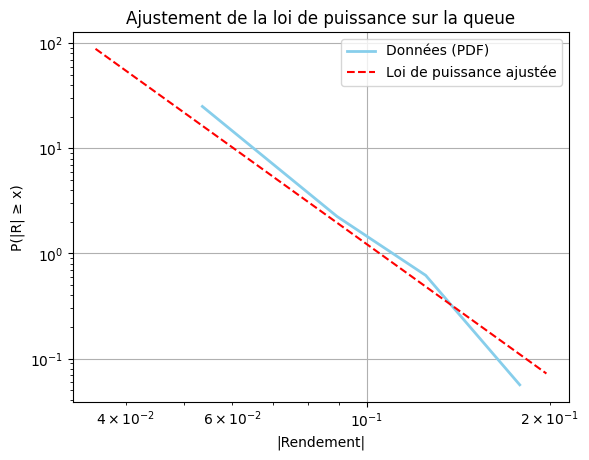

In [50]:
fig = fit.plot_pdf(color='skyblue', linewidth=2, label='Données (PDF)')
fit.power_law.plot_pdf(color='red', linestyle='--', ax=fig, label='Loi de puissance ajustée')
plt.xlabel('|Rendement|')
plt.ylabel('P(|R| ≥ x)')
plt.title('Ajustement de la loi de puissance sur la queue')
plt.legend()
plt.grid(True)
plt.show()


### Interprétation: en Daily Data

Le paquet `powerlaw` a ajusté une loi de puissance sur la queue de la distribution des rendements absolus, à partir d'une valeur minimale $ x_{\min} $ :

- **Exposant de la loi de puissance** :  
  $$
  \alpha = 4.16
  $$
  
- **Seuil d'application de la loi de puissance** :  
  $$
  x_{\min} \approx 0.0357
  $$

Cela signifie que pour les rendements absolus supérieurs à environ **3.6 %**, la distribution peut être modélisée par une loi de puissance du type :

$$
P(x) \sim x^{-\alpha} = x^{-4.16}
$$

Interprétation statistique et financière

- Comme $ \alpha > 3 $, la **moyenne et la variance** de cette distribution sont **finies**. Cela signifie que les moments d’ordre 1 et 2 existent.
- Néanmoins, une valeur de $ \alpha \approx 4.16 $ indique encore une **queue plus lourde** qu'une loi exponentielle, bien que **moins extrême** que ce qu'on observe parfois en finance (où $ \alpha \in [1.5, 3] $ est courant).
- Cette queue lourde suggère que **les événements extrêmes (forts rendements)** sont plus fréquents qu’avec une distribution normale ou exponentielle.




## 5.1.2 Exposant de la queue des log-returns : Data Intraday

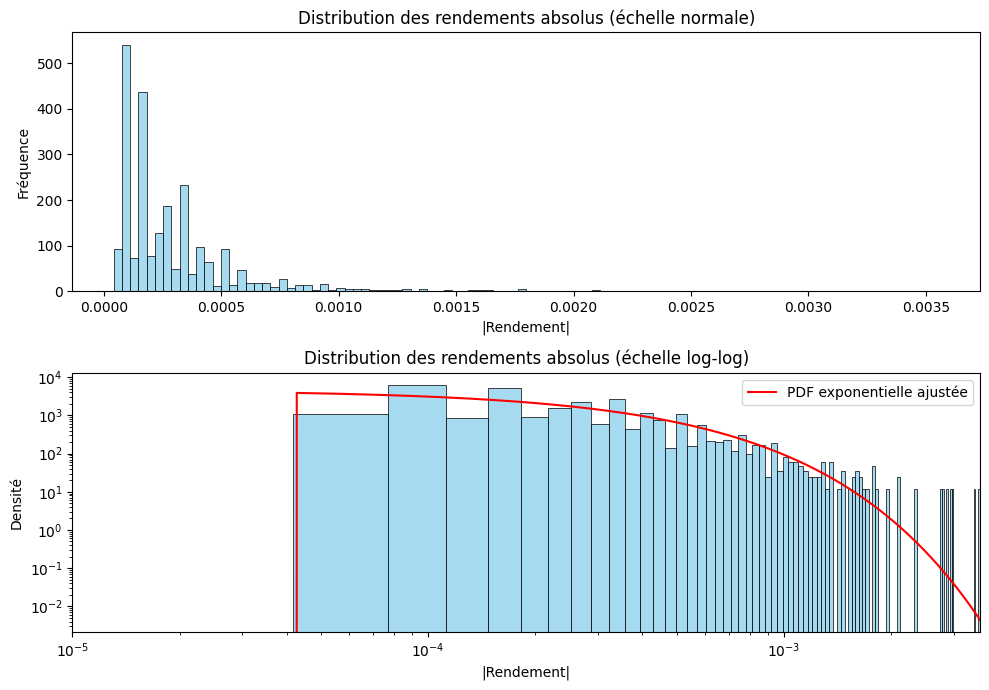

In [51]:
abs_returns_1m = np.abs(returns_1m)
loc, scale = stats.expon.fit(abs_returns_1m)   

x_fit = np.linspace(0, np.max(abs_returns_1m), 1000)
y_fit = stats.expon.pdf(x_fit, loc=loc, scale=scale)

fig, axes = plt.subplots(2, 1, figsize=(10, 7))

sns.histplot(abs_returns_1m, kde=False, ax=axes[0], bins=100, color='skyblue')
axes[0].set_title('Distribution des rendements absolus (échelle normale)')
axes[0].set_xlabel('|Rendement|')
axes[0].set_ylabel('Fréquence')

sns.histplot(abs_returns_1m, kde=False, stat='density', bins=100, ax=axes[1], color='skyblue')
sns.lineplot(x=x_fit, y=y_fit, color='red', ax=axes[1], label='PDF exponentielle ajustée')
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].set_xlim(1e-5, np.max(abs_returns_1m))
axes[1].set_xlabel('|Rendement|')
axes[1].set_ylabel('Densité')   
axes[1].set_title('Distribution des rendements absolus (échelle log-log)')
axes[1].legend()

plt.tight_layout()
plt.show()


Calculating best minimal value for power law fit


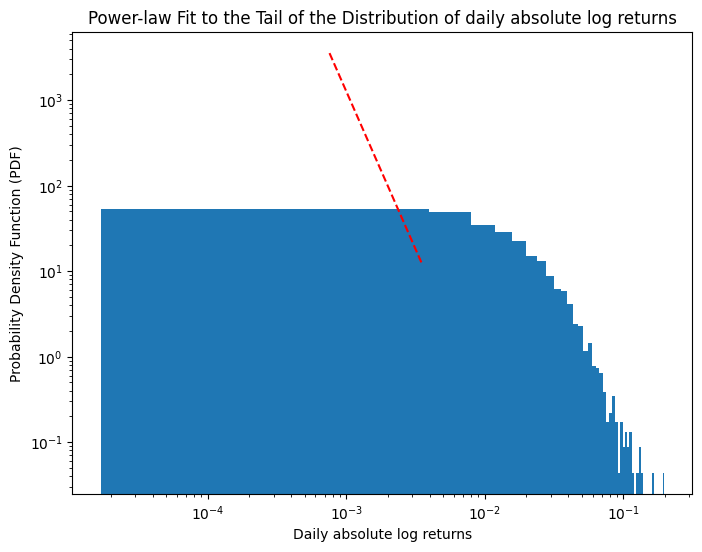

Power-law alpha: 3.6917796037379134
Power-law xmin: 0.0007573845350687947


In [52]:
fit = powerlaw.Fit(np.abs(returns_1m))

plt.figure(figsize=(8, 6))

alpha = fit.power_law.alpha
xmin = fit.power_law.xmin
plt.hist(np.abs(returns_daily), bins=50, density=True)
fit.power_law.plot_pdf(color='r', linestyle='--')

plt.xlabel('Daily absolute log returns')
plt.ylabel('Probability Density Function (PDF)')
plt.title('Power-law Fit to the Tail of the Distribution of daily absolute log returns')
plt.show()

print(f"Power-law alpha: {alpha}")
print(f"Power-law xmin: {xmin}")

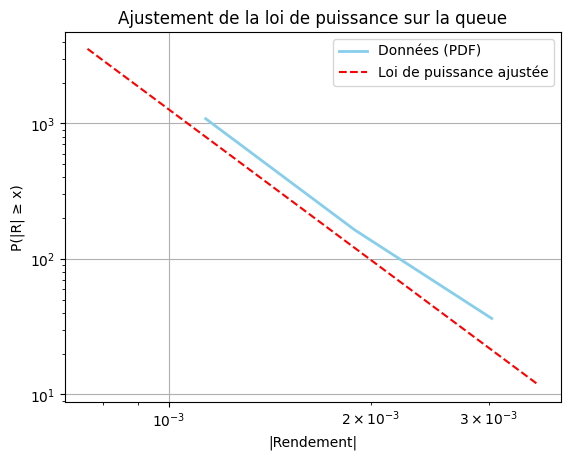

In [53]:
fig = fit.plot_pdf(color='skyblue', linewidth=2, label='Données (PDF)')
fit.power_law.plot_pdf(color='red', linestyle='--', ax=fig, label='Loi de puissance ajustée')
plt.xlabel('|Rendement|')
plt.ylabel('P(|R| ≥ x)')
plt.title('Ajustement de la loi de puissance sur la queue')
plt.legend()
plt.grid(True)
plt.show()

Nous avons ajusté une loi de puissance à la distribution des rendements absolus **intraday** (fréquence : 1 minute), en utilisant le paquet `powerlaw`.

Les résultats de l'ajustement sont les suivants :

- **Exposant de la loi de puissance** :
  $$
  \alpha = 3.69
  $$

- **Seuil de la loi de puissance (xmin)** :
  $$
  x_{\min} \approx 0.00076
  $$

Cela signifie que pour les rendements absolus supérieurs à **0.076 %** (très faibles, mais significatifs à haute fréquence), la distribution des rendements suit une loi de puissance :

$$
P(x) \sim x^{-3.69}
$$


### Interprétation statistique et implications

- L’exposant $ \alpha = 3.69 > 3 $ indique que :
  - La **moyenne** et la **variance** de la distribution sont **finies**,
  - Les événements extrêmes sont **moins fréquents** que dans des lois de puissance à $ \alpha < 3 $, mais toujours **plus fréquents** que dans une loi exponentielle ou normale.
- Par comparaison avec les rendements journaliers ($ \alpha \approx 4.16 $), les rendements intraday montrent une **queue plus épaisse**, donc **plus de volatilité locale**.
- Le fait que $ x_{\min} $ soit très petit est cohérent avec des données haute fréquence, où les rendements sont naturellement plus faibles.


### 6.1.1. Présence d'une loi de puissance / Comparaisons et significativité : Data Journalières 

In [54]:
fit = powerlaw.Fit(np.abs(returns_daily), xmin=None, discrete=False)

R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
print(f"Comparaison power-law vs exponentielle :")
print(f"  LLR (R) = {R_exp:.4f}, p-value = {p_exp:.4f}")

R_lognorm, p_lognorm = fit.distribution_compare('power_law', 'lognormal')
print(f"\nComparaison power-law vs log-normale :")
print(f"  LLR (R) = {R_lognorm:.4f}, p-value = {p_lognorm:.4f}")


Calculating best minimal value for power law fit
Comparaison power-law vs exponentielle :
  LLR (R) = 8.2972, p-value = 0.2007

Comparaison power-law vs log-normale :
  LLR (R) = -1.8332, p-value = 0.2427


Comme tu laisses xmin=None, le paquet utilise automatiquement la meilleure estimation de xmin pour faire la comparaison, ce qui est la bonne pratique.

L’exposant positif de $ R $ indique que la **loi de puissance est préférable** à la loi exponentielle.  
Cependant, la **valeur de p = 0.144** est **supérieure à 0.05**, ce qui signifie que cette préférence **n’est pas statistiquement significative**.

Raisons : le **niveau de bruit plus élevé** dans les données à la minute
un **nombre insuffisant d’événements extrêmes** pour trancher fermement ?


> **Conclusion** : on **ne peut pas rejeter** la possibilité que la distribution soit exponentielle.  
Cela signifie que **les queues lourdes ne sont pas statistiquement établies** dans les rendements intraday à la minute.

### 6.1.2. Présence d'une loi de puissance / Comparaisons et significativité : Data Intraday

In [55]:
fit = powerlaw.Fit(np.abs(returns_1m), xmin=None, discrete=False)

R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
print(f"Comparaison power-law vs exponentielle :")
print(f"  LLR (R) = {R_exp:.4f}, p-value = {p_exp:.4f}")

R_lognorm, p_lognorm = fit.distribution_compare('power_law', 'lognormal')
print(f"\nComparaison power-law vs log-normale :")
print(f"  LLR (R) = {R_lognorm:.4f}, p-value = {p_lognorm:.4f}")

Calculating best minimal value for power law fit
Comparaison power-law vs exponentielle :
  LLR (R) = 5.2464, p-value = 0.1444

Comparaison power-law vs log-normale :
  LLR (R) = -0.2365, p-value = 0.6384


## Partie 2 : Distribution des rendements dans les marchés en fonction des régimes (hausses/baisses)

In [66]:
tickers = ['^GSPC','AMD','MSFT','INTC','C', 'AAPL']
market = yf.download(tickers, start='1900-01-01')['Close']

[*********************100%***********************]  6 of 6 completed


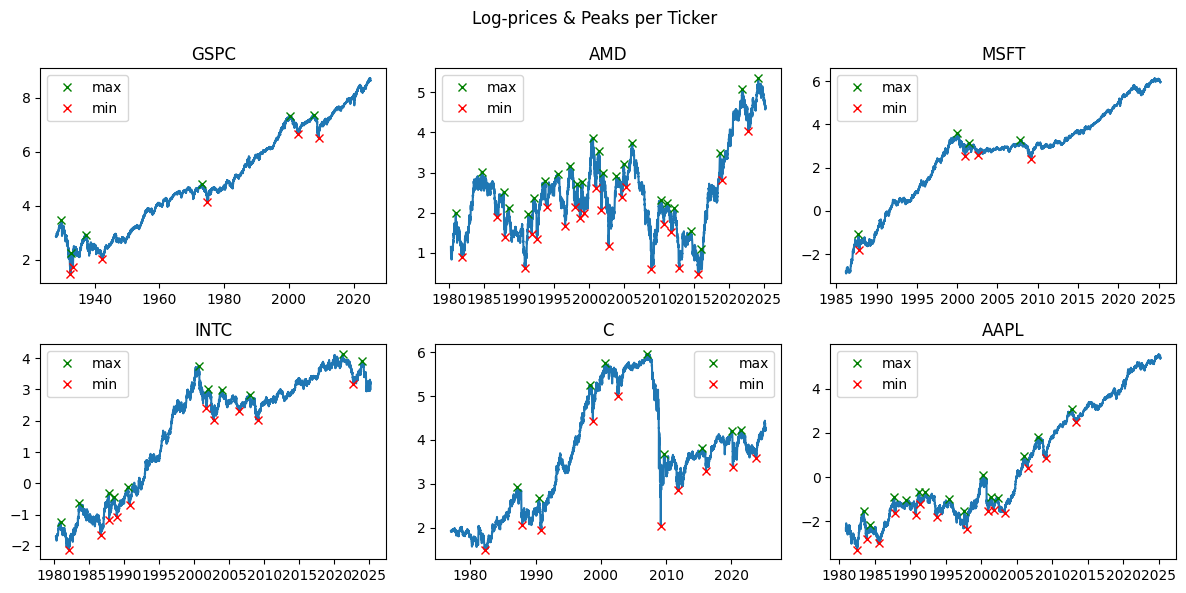

In [67]:
fig = plt.figure(figsize=(12, 6))
for i, ticker in enumerate(tickers):
    df = market[ticker].dropna().to_frame(name='price')
    df['log-price'] = np.log(df['price'])

    prices = df['log-price'].values

    # trouver les pics qui sont significatifs seulement deux fois par an
    peaks_max, _ = find_peaks(prices, distance=252/2, prominence=0.5)
    peaks_min, _ = find_peaks(-prices, distance=252/2, prominence=0.5)

    ax = fig.add_subplot(2, 3, i+1)
    ax.plot(df.index, prices)
    ax.plot(df.index[peaks_max], prices[peaks_max], "x", color="g", label='max')
    ax.plot(df.index[peaks_min], prices[peaks_min], "x", color="r", label='min')
    ax.set_title(ticker.replace('^GSPC', 'GSPC'))
    ax.legend()

plt.suptitle("Log-prices & Peaks per Ticker")
plt.tight_layout()
plt.show()

In [68]:
def find_periods(logprice, peaks_max, peaks_min):
    # Combine all peak indices + start (0) + end (last index)
    peaks = np.sort(np.concatenate(([0], peaks_max, peaks_min, [len(logprice) - 1])))

    bull_market = []
    bear_market = []

    # Iterate through each segment between consecutive peaks
    for start, end in zip(peaks[:-1], peaks[1:]):
        if logprice[end] > logprice[start]:
            bull_market.extend(range(start, end))
        else:
            bear_market.extend(range(start, end))

    return bull_market, bear_market

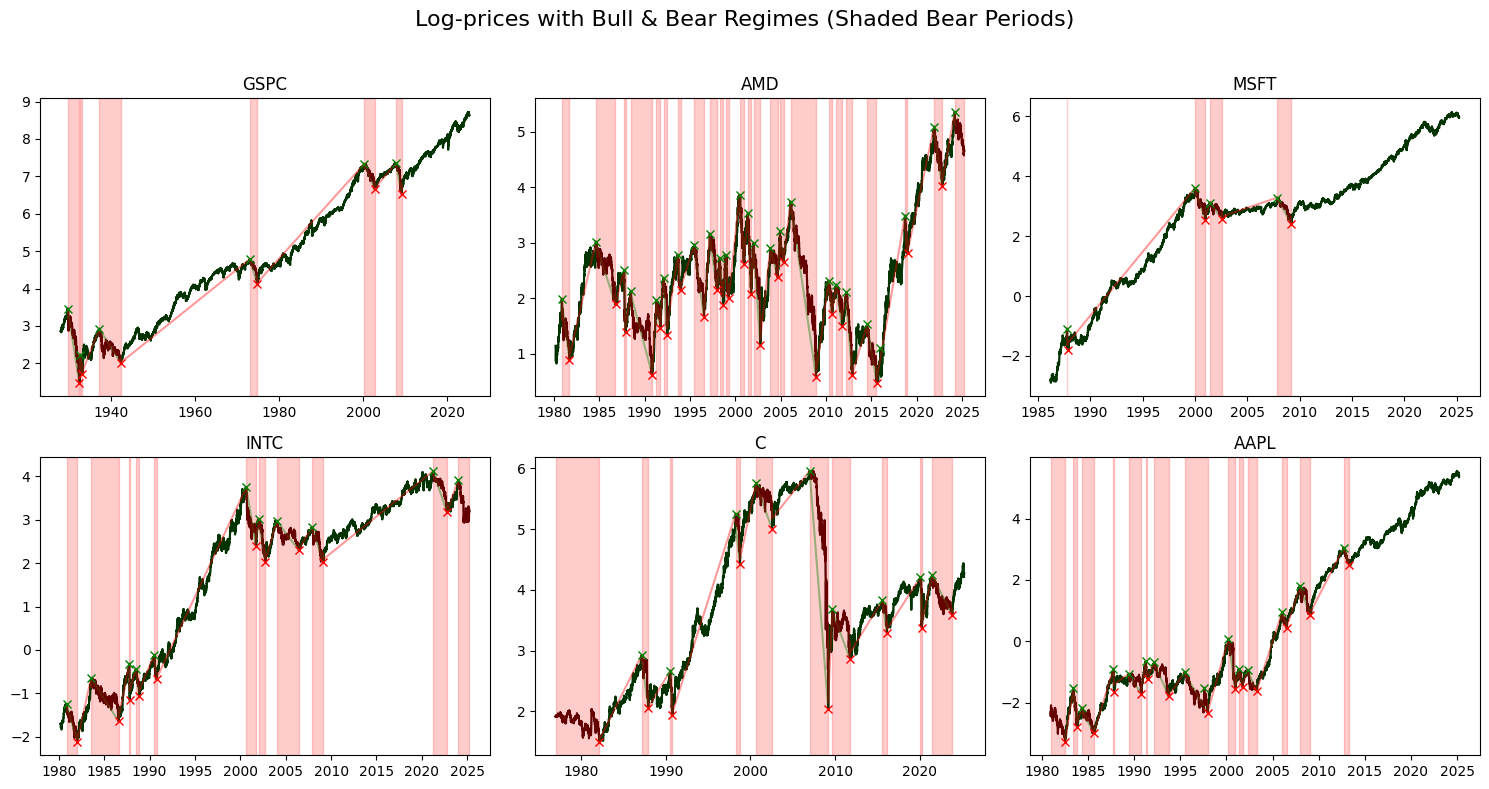

In [69]:
fig = plt.figure(figsize=(15, 8))
for i, ticker in enumerate(tickers):
    df = market[ticker].dropna().to_frame(name='price')
    df['log-price'] = np.log(df['price'])
    prices = df['log-price'].values

    peaks_max, _ = find_peaks(prices, distance=126, prominence=0.5)
    peaks_min, _ = find_peaks(-prices, distance=126, prominence=0.5)

    # Identifier les périodes haussières et baissières
    bull_idxs, bear_idxs = find_periods(prices, peaks_max, peaks_min)

    dates = df.index

    # Régimes
    bear_flags = np.zeros(len(prices), dtype=bool)
    bear_flags[bear_idxs] = True

    bear_ranges = []
    for k, g in groupby(enumerate(bear_idxs), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        start_date = dates[group[0]]
        end_date = dates[group[-1]]
        bear_ranges.append((start_date, end_date))

    ax = fig.add_subplot(2, 3, i+1)
    
    for start, end in bear_ranges:
        ax.axvspan(start, end, color='red', alpha=0.2)

    ax.plot(dates, prices, label='log-price', color='black')

    ax.plot(dates[bull_idxs], prices[bull_idxs], color='green', alpha=0.4, label='Bull Market')
    ax.plot(dates[bear_idxs], prices[bear_idxs], color='red', alpha=0.4, label='Bear Market')

    ax.plot(dates[peaks_max], prices[peaks_max], "x", color="g", label='Max')
    ax.plot(dates[peaks_min], prices[peaks_min], "x", color="r", label='Min')

    ax.set_title(ticker.replace('^GSPC', 'GSPC'))

plt.suptitle("Log-prices with Bull & Bear Regimes (Shaded Bear Periods)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [70]:
dico_market = {}

for ticker in tickers:
    df = market[ticker].dropna().to_frame(name='price')
    df['log-price'] = np.log(df['price'])
    df['log_ret'] = df['log-price'].diff()
    df = df.dropna()

    prices = df['log-price'].values
    returns = df['log_ret'].values

    peaks_max, _ = find_peaks(prices, distance=126, prominence=0.5)
    peaks_min, _ = find_peaks(-prices, distance=126, prominence=0.5)

    bull_idxs, bear_idxs = find_periods(prices, peaks_max, peaks_min)

    # Créer une colonne "periods" : 1 = bull, 0 = bear
    periods = np.zeros(len(df), dtype=int)
    periods[bull_idxs] = 1
    df['periods'] = periods

    dico_market[ticker] = df

In [71]:
cdflr_bull = {}
cdflr_bear = {}

for ticker in dico_market:
    df = dico_market[ticker]
    
    log_ret_bull = df[df["periods"] == 1]["log_ret"]
    log_ret_bear = df[df["periods"] == 0]["log_ret"]

    cdflr_bull[ticker] = ECDF(log_ret_bull.to_numpy())
    cdflr_bear[ticker] = ECDF(log_ret_bear.to_numpy())


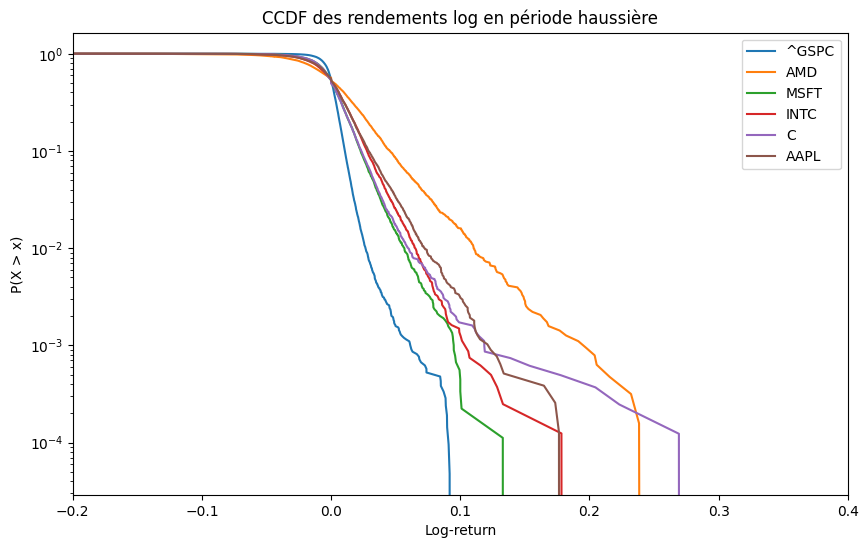

In [72]:
# CCDF des rendements en période haussière
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(cdflr_bull[ticker].x, 1 - cdflr_bull[ticker].y, label=ticker)
plt.legend()
plt.yscale('log')
plt.title('CCDF des rendements log en période haussière')
plt.xlabel('Log-return')
plt.ylabel('P(X > x)')
plt.xlim(-0.2, 0.4)
plt.show()

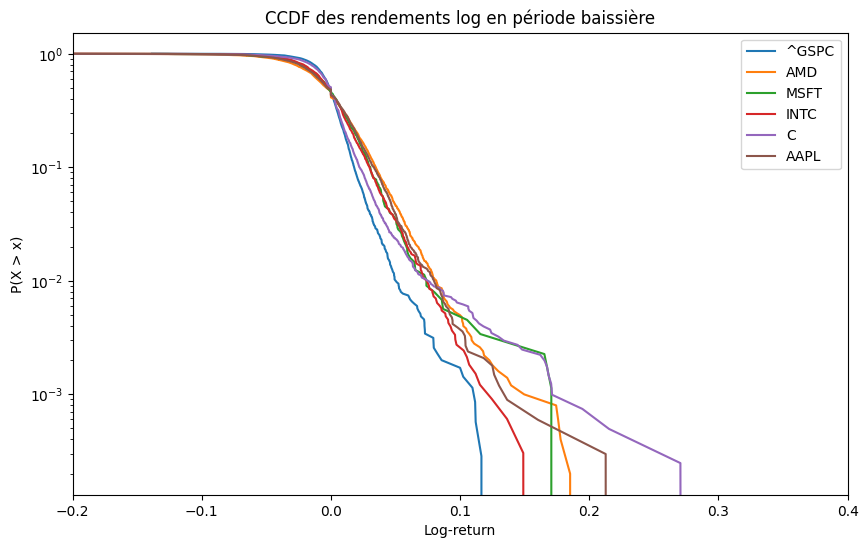

In [73]:
# CCDF des rendements en période baissière
plt.figure(figsize=(10, 6))
for ticker in tickers:
    plt.plot(cdflr_bear[ticker].x, 1 - cdflr_bear[ticker].y, label=ticker)
plt.legend()
plt.yscale('log')
plt.title('CCDF des rendements log en période baissière')
plt.xlabel('Log-return')
plt.ylabel('P(X > x)')
plt.xlim(-0.2, 0.4)
plt.show()

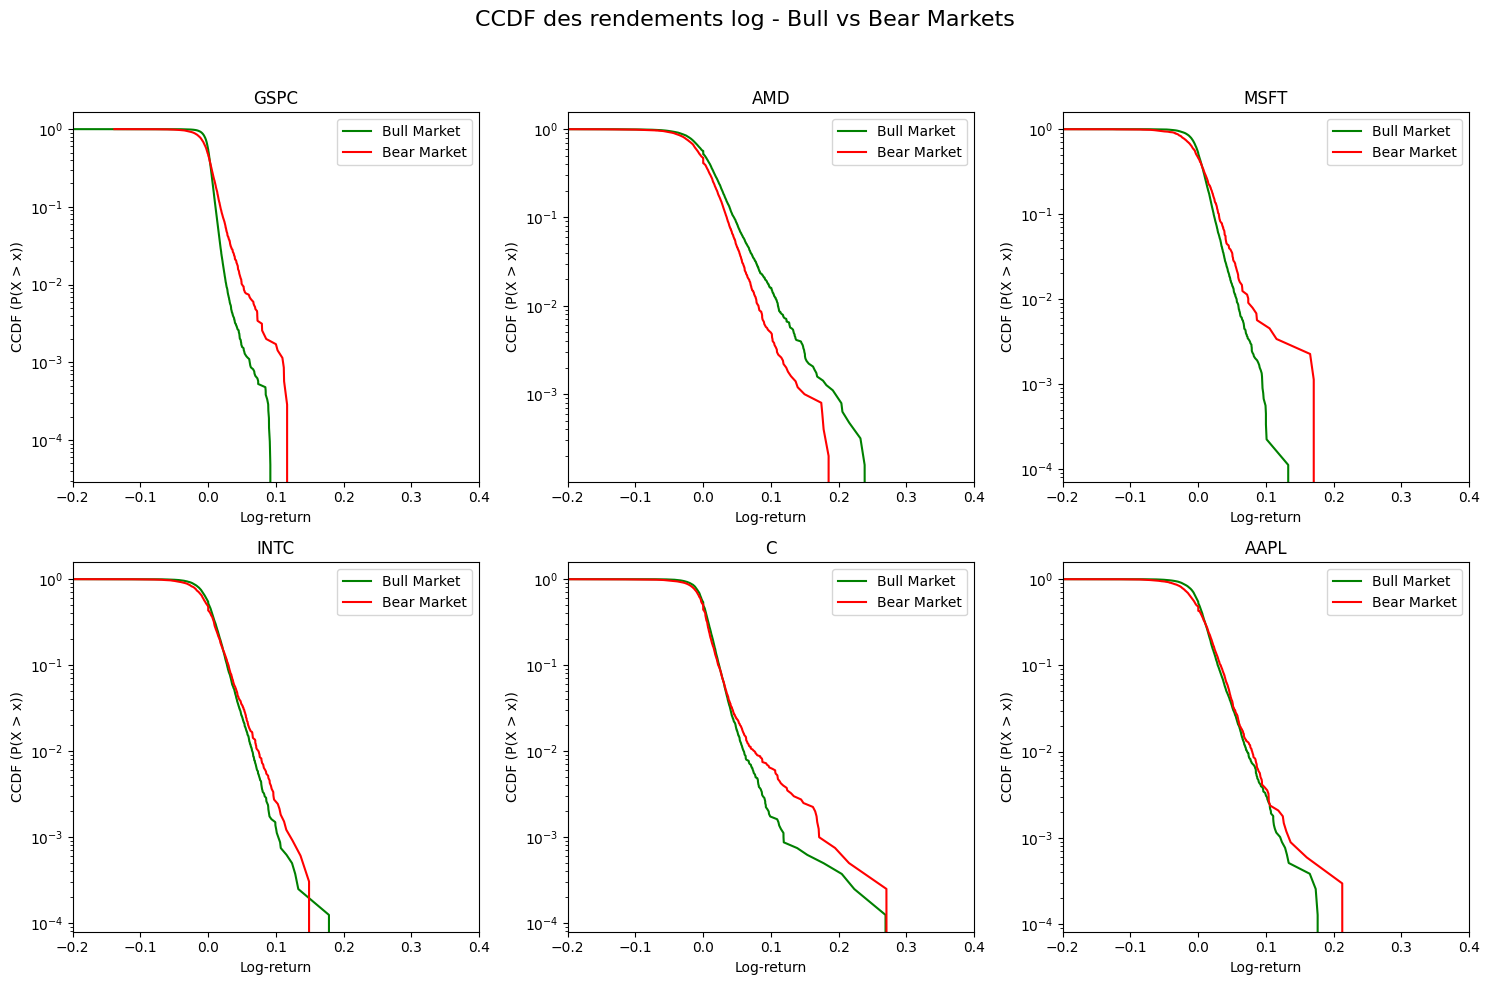

In [75]:
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.ravel()

for i, ticker in enumerate(tickers):
    ax = axs[i]

    ax.plot(cdflr_bull[ticker].x, 1 - cdflr_bull[ticker].y, label='Bull Market', color='green')
    ax.plot(cdflr_bear[ticker].x, 1 - cdflr_bear[ticker].y, label='Bear Market', color='red')
    
    ax.set_yscale('log')
    ax.set_xlim(-0.2, 0.4)
    ax.set_title(ticker.replace('^GSPC', 'GSPC'))
    ax.set_xlabel('Log-return')
    ax.set_ylabel('CCDF (P(X > x))')
    ax.legend()

# S'il y a moins de 6 tickers, cacher les axes vides
for j in range(len(tickers), 6):
    fig.delaxes(axs[j])

plt.suptitle("CCDF des rendements log - Bull vs Bear Markets", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


### Interprétation :

On voit deux choses : 

- la premières est que GSPC étant un index comprenant 500 stocks, il a un comportement différent au niveau de ces queues de distribution (ce qui est logique car il définit le marché et est sensé être moins idiosyncratique à des évènements extrêmes étant weighté par les stocks le composant)

- A part AMD qui a énormément de cycles différents, les autres stocks montrent une claire vue sur le fait que les news négatives ont un impact plus fort sur les évènements extrêmes, encore une fois rien de choquant, les hausses extrêmes sont généralement progressives et les baisses extrêmes sont plus synonymes de panique.

#### Conclusion :

Il est intéressant de séparer bull et bear regime shift pour les assets dans l'études des rendements.

In [78]:
results = []

for ticker in tickers:
    df = dico_market[ticker]

    for label, period_val in [('Bull', 1), ('Bear', 0)]:
        data = np.abs(df[df['periods'] == period_val]['log_ret'].dropna())

        if len(data) < 100:  # sécurité si pas assez de données
            continue

        fit = powerlaw.Fit(data, verbose=False)

        alpha = fit.power_law.alpha
        xmin = fit.power_law.xmin

        # Comparaisons de distributions
        R_exp, p_exp = fit.distribution_compare('power_law', 'exponential')
        R_log, p_log = fit.distribution_compare('power_law', 'lognormal')

        results.append({
            'Ticker': ticker.replace('^GSPC', 'GSPC'),
            'Market': label,
            'Alpha (PL)': round(alpha, 3),
            'xmin': round(xmin, 5),
            'LLR PL vs Exp': round(R_exp, 3),
            'p-value Exp': round(p_exp, 4),
            'LLR PL vs LogNorm': round(R_log, 3),
            'p-value LogNorm': round(p_log, 4)
        })

results_df = pd.DataFrame(results)

/Users/hugo/Library/Python/3.9/lib/python/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.


In [79]:
results_df

,Ticker,Market,Alpha (PL),xmin,LLR PL vs Exp,p-value Exp,LLR PL vs LogNorm,p-value LogNorm
0,GSPC,Bull,3.784,0.02013,47.054,0.0017,-0.988,0.4168
1,GSPC,Bear,4.139,0.04093,-1.364,0.5930,-1.840,0.1904
2,AMD,Bull,5.538,0.15028,0.854,0.4805,0.000,0.8960
3,AMD,Bear,3.841,0.05321,33.521,0.0074,-0.108,0.7979
4,MSFT,Bull,4.319,0.03713,6.406,0.3428,-2.226,0.2171
5,MSFT,Bear,3.033,0.02565,9.340,0.3584,-3.358,0.1710
6,INTC,Bull,4.895,0.05588,11.031,0.0213,-1.659,0.0002
7,INTC,Bear,4.418,0.06314,5.159,0.1969,-0.039,0.8705
8,C,Bull,3.805,0.03209,45.852,0.0028,-0.377,0.6445
9,C,Bear,2.940,0.03031,62.128,0.0001,-1.003,0.3733


### Conclusion Partie 2 :

- La loi de puissance est globalement plus adaptée en période de crise pour certains titres, en particulier C, AMD, GSPC et en période haussière très forte : GSPC, C, INTC.

- Les alpha sont souvent plus faibles en période baissière, ce qui signifie une queue plus lourde, la distribution des rendements en période baissière est une épaisse.

- On voit que l'hypothèse de log-normalité vs une powerlaw est invalidé sur la majorité des titres.

## Partie 3 : Disparition de la prévisibilité